# Train an LSTM classifier on fMRI activity of visual regions of the brain to predict type of visual stimuli

Here, we will train a simple LSTM to predict which type of image was seen based on the brain activity of visual regions. For the first pass, we will simply classify whether the image came from ImageNet, COCO, or SUN. These databses have distinct types of images: focused single object, naturalistic objects, environmental scenes, respectively.

We will train a separate LSTM for each of the ten brain regions that were extracted from each subject viewing these images. Perhaps we will find that in isolation neither region provides enough information to successfully classify, or one or two region will have particular higher accuracies. Whatever result we find will dictate how we proceed next. Maybe we can train combining all regions into one large training set, or use stacked LSTMs or hierarchical LSTMs. Let's find out using Keras.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU
from sklearn.model_selection import train_test_split


data_dir = 'dataset/traindata/'

Using TensorFlow backend.


### First pass

Let's train an LSTM using some default hyperparameters.

In [23]:
import pickle
from sklearn.feature_selection import SelectKBest, f_classif

"""
Load class numbers associated with each image as one-hot vectors
"""
def load_classes(Y, encoding = 'onehot'):
    if encoding not in ['onehot', 'interval']:
        raise ValueError('incorrect type of encoding')
    df = pd.read_csv(os.path.join(data_dir, 'image2labels.tsv'), sep='\t', header = None, names = ['ImgName', 'ClassNum', 'ClassLabel'])
    image2class = pd.Series(df.ClassNum.values,index=df.ImgName).to_dict()
    max_class_num = np.max(list(image2class.values()))
    if encoding == 'onehot':
        Y_out = np.zeros((Y.shape[0], max_class_num+2))
        for ind,img in enumerate(Y):
            if img == 'none':
                Y_out[ind][max_class_num+1] = 1
            else:
                Y_out[ind][image2class[img]] = 1
    elif encoding == 'interval':
        Y_out = np.zeros((Y.shape[0],))
        for ind,img in enumerate(Y):
            if img == 'none':
                Y_out[ind] = max_class_num + 1
            else:
                Y_out[ind] = image2class[img]
    
    return Y_out
        

"""
Subtract the mean signal from the resting state data
"""
def rest_normalize(X,Y):
    with open('dataset/traindata/sample2session.p', 'rb') as f:
        sample2session = pickle.load(f)
    subjects = list(set(sample2session['Subject']))
    baseline = {}
    for sub in subjects:
        rest = np.array([x for ind,x in enumerate(X) if Y[ind][16] == 1 and sample2session['Subject'].values[ind] == sub])
        baseline[sub] = np.mean(rest, axis = (0,1))
    X_new = np.array([x - baseline[sample2session['Subject'].values[ind]] for ind,x in enumerate(X)])
    
    return X_new    
    

"""
Load in the dataset.

Return train, dev, test splits, standardized
"""
def load_data(dim_reduce = False, num_dims = 1000):
    # Load from disk
    with open(data_dir + 'X_raw.p', 'rb') as f:
        X = np.array(pickle.load(f))
    with open(data_dir + 'Y_raw.p', 'rb') as f:
        Yimages = np.array(pickle.load(f))
    if dim_reduce:
        classes = load_classes(Yimages, encoding = 'interval')
        X_mean = np.mean(X, axis=1)
        kbest = SelectKBest(f_classif, k = num_dims).fit(X_mean,classes)
        best_voxels = np.argsort(kbest.scores_)[::-1][:num_dims]
        X = X[:,:,best_voxels]
    # Convert class labels as one hot vectors
    classes = load_classes(Yimages)
    # Standardize data
    X_scaled = rest_normalize(X, classes)
    # Split into train,dev,test
    X_train, X_devtest, Y_train, Y_devtest = train_test_split(X_scaled, classes, test_size = 0.4)
    X_dev, X_test, Y_dev, Y_test = train_test_split(X_devtest, Y_devtest, test_size = 0.5)
    
    print('%20s %20s' % ('Shape of X_train:', str(X_train.shape)))
    print('%20s %20s' % ('Shape of Y_train:', str(Y_train.shape)))
    print('%20s %20s' % ('Shape of X_dev:', str(X_dev.shape)))
    print('%20s %20s' % ('Shape of Y_dev:', str(Y_dev.shape)))
    print('%20s %20s' % ('Shape of X_test:', str(X_test.shape)))
    print('%20s %20s' % ('Shape of Y_test:', str(Y_test.shape)))
    
    return X_train, X_dev, X_test, Y_train, Y_dev, Y_test

In [24]:
# Load with reduced dimensions
X_train, X_dev, X_test, Y_train, Y_dev, Y_test = load_data(dim_reduce = False)

   Shape of X_train:     (11628, 5, 9598)
   Shape of Y_train:          (11628, 17)
     Shape of X_dev:      (3876, 5, 9598)
     Shape of Y_dev:           (3876, 17)
    Shape of X_test:      (3876, 5, 9598)
    Shape of Y_test:           (3876, 17)


In [28]:
"""
Create LSTM model using given hyperparameters

"""
def create_model(n_timesteps, n_features, n_hidden, n_classes, dropout = 0.5):
    model = Sequential()
    model.add(GRU(n_hidden, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(dropout))
    #model.add(Dense(n_hidden, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [29]:
n_timesteps, n_features, n_classes = X_train.shape[1], X_train.shape[2], Y_train.shape[1]
n_hidden = 100
dropout = 0.5

model = create_model(n_timesteps, n_features, n_hidden, n_classes, dropout = dropout)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 100)               2909700   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 17)                1717      
Total params: 2,911,417
Trainable params: 2,911,417
Non-trainable params: 0
_________________________________________________________________


In [30]:
"""
Train model and output train and dev accuracy history

"""

def train_model(model, X_train, X_dev, Y_train, Y_dev, epochs, batch_size = 64, verbose = 1):
    train_history = model.fit(X_train, Y_train, validation_data = (X_dev, Y_dev), epochs=epochs, batch_size=batch_size, verbose=verbose)
    train_acc,dev_acc = train_history.history['accuracy'], train_history.history['val_accuracy']
    
    return model,train_acc, dev_acc

In [31]:
model, train_acc, dev_acc = train_model(model, X_train, X_dev, Y_train, Y_dev, 30, batch_size = 64)

Train on 11628 samples, validate on 3876 samples
Epoch 1/30
11628/11628 [==============================] - 32s 3ms/step - loss: 3.3815 - accuracy: 0.0842 - val_loss: 2.8260 - val_accuracy: 0.1102
Epoch 2/30
11628/11628 [==============================] - 29s 3ms/step - loss: 3.0143 - accuracy: 0.1022 - val_loss: 2.7290 - val_accuracy: 0.1161
Epoch 3/30
11628/11628 [==============================] - 29s 3ms/step - loss: 2.7984 - accuracy: 0.1224 - val_loss: 2.6708 - val_accuracy: 0.1324
Epoch 4/30
11628/11628 [==============================] - 29s 3ms/step - loss: 2.7164 - accuracy: 0.1305 - val_loss: 2.6346 - val_accuracy: 0.1393
Epoch 5/30
11628/11628 [==============================] - 29s 2ms/step - loss: 2.6594 - accuracy: 0.1427 - val_loss: 2.6258 - val_accuracy: 0.1406
Epoch 6/30
11628/11628 [==============================] - 29s 3ms/step - loss: 2.6232 - accuracy: 0.1521 - val_loss: 2.6051 - val_accuracy: 0.1574
Epoch 7/30
11628/11628 [==============================] - 30s 3ms/ste

In [32]:
"""
Plot the training history
"""
def plot_acc(train_acc, dev_acc, title = 'LSTM model accuracy'):
    plt.close('all')
    fig, ax = plt.subplots(1,1, figsize = (6,4))
    ax.plot(train_acc, color = 'blue', label = 'train')
    ax.plot(dev_acc, color = 'green', label = 'dev')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title(title)
    ax.legend()
    plt.show()

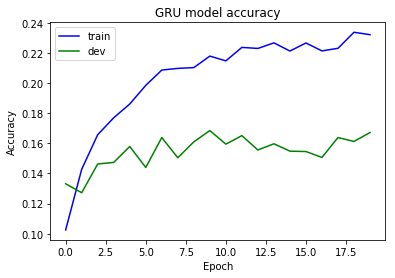

In [35]:
plot_acc(train_acc, dev_acc, title = 'GRU model accuracy')

In [ ]:
dropout = 0.5
n_hidden = 500
model = create_model(n_timesteps, n_features, n_hidden, n_classes, dropout = dropout)
model, train_acc, dev_acc = train_model(model, X_train, X_dev, Y_train, Y_dev, epochs = 20, batch_size = 64, verbose = 1)

Train on 11628 samples, validate on 3876 samples
Epoch 1/20
 4480/11628 [==========>...................] - ETA: 1:46 - loss: 3.5481 - accuracy: 0.0879

It is clearly overfitting, maybe we can try to reduce the variance. How about increasing dropout?

In [30]:
dropout = 0.8
n_hidden = 100
model = create_model(n_timesteps, n_features, n_hidden, n_classes, dropout = dropout)
model, train_acc, dev_acc = train_model(model, X_train, X_dev, Y_train, Y_dev, epochs = 20, batch_size = 64, verbose = 1)

W1120 18:38:13.326150 140042351974144 nn_ops.py:4283] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Train on 11628 samples, validate on 3876 samples
Epoch 1/20
11628/11628 [==============================] - 4s 342us/step - loss: 3.4526 - accuracy: 0.1011 - val_loss: 2.5688 - val_accuracy: 0.1705
Epoch 2/20
11628/11628 [==============================] - 3s 293us/step - loss: 2.9534 - accuracy: 0.1298 - val_loss: 2.5194 - val_accuracy: 0.1852
Epoch 3/20
11628/11628 [==============================] - 3s 296us/step - loss: 2.7090 - accuracy: 0.1540 - val_loss: 2.4760 - val_accuracy: 0.1950
Epoch 4/20
11628/11628 [==============================] - 3s 298us/step - loss: 2.5839 - accuracy: 0.1722 - val_loss: 2.4624 - val_accuracy: 0.1974
Epoch 5/20
11628/11628 [==============================] - 3s 298us/step - loss: 2.5166 - accuracy: 0.1858 - val_loss: 2.4422 - val_accuracy: 0.2121
Epoch 6/20
11628/11628 [==============================] - 3s 297us/step - loss: 2.4657 - accuracy: 0.2021 - val_loss: 2.4275 - val_accuracy: 0.2183
Epoch 7/20
11628/11628 [==============================] - 3s 29

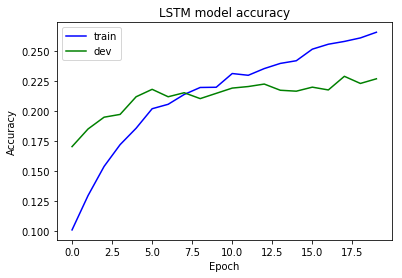

In [31]:
plot_acc(train_acc, dev_acc)

That did not improve our validation error. How about keeping dropout but changing the number of hidden nodes?

In [33]:
dropout = 0.5
n_hidden = 50
model = create_model(n_timesteps, n_features, n_hidden, n_classes, dropout = dropout)
model, train_acc, dev_acc = train_model(model, X_train, X_dev, Y_train, Y_dev, epochs = 30, batch_size = 64, verbose = 1)

Train on 11628 samples, validate on 3876 samples
Epoch 1/30
11628/11628 [==============================] - 3s 231us/step - loss: 2.8701 - accuracy: 0.1247 - val_loss: 2.5710 - val_accuracy: 0.1770
Epoch 2/30
11628/11628 [==============================] - 2s 185us/step - loss: 2.6294 - accuracy: 0.1707 - val_loss: 2.5132 - val_accuracy: 0.1907
Epoch 3/30
11628/11628 [==============================] - 2s 178us/step - loss: 2.5108 - accuracy: 0.2016 - val_loss: 2.4997 - val_accuracy: 0.1922
Epoch 4/30
11628/11628 [==============================] - 2s 181us/step - loss: 2.4408 - accuracy: 0.2096 - val_loss: 2.4648 - val_accuracy: 0.2025
Epoch 5/30
11628/11628 [==============================] - 2s 180us/step - loss: 2.3863 - accuracy: 0.2303 - val_loss: 2.4442 - val_accuracy: 0.2147
Epoch 6/30
11628/11628 [==============================] - 2s 185us/step - loss: 2.3470 - accuracy: 0.2449 - val_loss: 2.4474 - val_accuracy: 0.2116
Epoch 7/30
11628/11628 [==============================] - 2s 18

KeyboardInterrupt: 

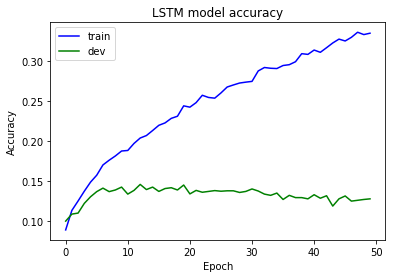

In [13]:
plot_acc(train_acc, dev_acc)

Decreasing number of hidden units may not help either... the other alternative is to get more data. We may have to use multiple regions to train one model. We can first train an individual model for each region to see if any region can get good accuracy. Then we can try combining the regions. If none of those improve performance, then we'll have to look into combining multiple LSTMs.

### One model per region

   Shape of X_train:      (11628, 5, 100)
   Shape of Y_train:          (11628, 17)
     Shape of X_dev:       (3876, 5, 100)
     Shape of Y_dev:           (3876, 17)
    Shape of X_test:       (3876, 5, 100)
    Shape of Y_test:           (3876, 17)


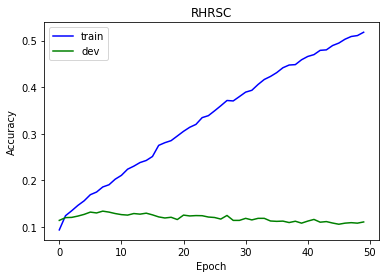

   Shape of X_train:      (11628, 5, 190)
   Shape of Y_train:          (11628, 17)
     Shape of X_dev:       (3876, 5, 190)
     Shape of Y_dev:           (3876, 17)
    Shape of X_test:       (3876, 5, 190)
    Shape of Y_test:           (3876, 17)


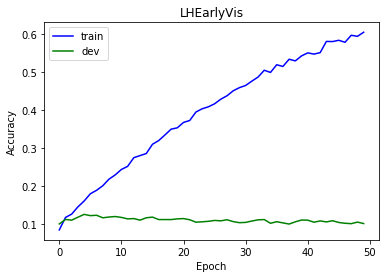

   Shape of X_train:       (11628, 5, 70)
   Shape of Y_train:          (11628, 17)
     Shape of X_dev:        (3876, 5, 70)
     Shape of Y_dev:           (3876, 17)
    Shape of X_test:        (3876, 5, 70)
    Shape of Y_test:           (3876, 17)


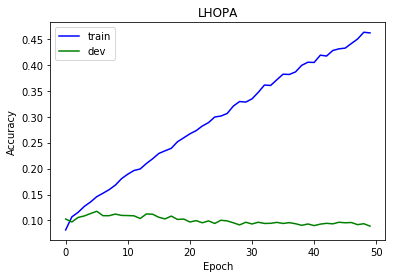

   Shape of X_train:       (11628, 5, 80)
   Shape of Y_train:          (11628, 17)
     Shape of X_dev:        (3876, 5, 80)
     Shape of Y_dev:           (3876, 17)
    Shape of X_test:        (3876, 5, 80)
    Shape of Y_test:           (3876, 17)


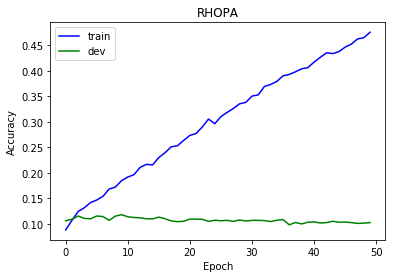

   Shape of X_train:      (11628, 5, 130)
   Shape of Y_train:          (11628, 17)
     Shape of X_dev:       (3876, 5, 130)
     Shape of Y_dev:           (3876, 17)
    Shape of X_test:       (3876, 5, 130)
    Shape of Y_test:           (3876, 17)


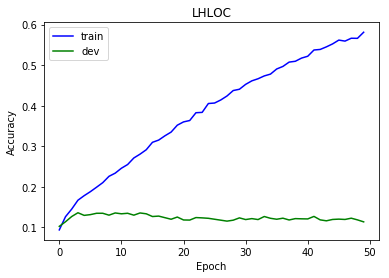

   Shape of X_train:      (11628, 5, 170)
   Shape of Y_train:          (11628, 17)
     Shape of X_dev:       (3876, 5, 170)
     Shape of Y_dev:           (3876, 17)
    Shape of X_test:       (3876, 5, 170)
    Shape of Y_test:           (3876, 17)


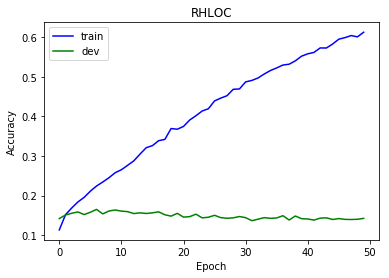

   Shape of X_train:       (11628, 5, 30)
   Shape of Y_train:          (11628, 17)
     Shape of X_dev:        (3876, 5, 30)
     Shape of Y_dev:           (3876, 17)
    Shape of X_test:        (3876, 5, 30)
    Shape of Y_test:           (3876, 17)


KeyboardInterrupt: 

In [25]:
n_hidden = 100
dropout = 0.5
epochs = 50

masks = set([f.split('_')[1][:-4] for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir,f)) and '.npy' in f and 'all' not in f])

region_acc = {}

for mask in masks:   
    X_train, X_dev, X_test, Y_train, Y_dev, Y_test = load_region_data(mask)
    n_timesteps, n_features, n_classes = X_train.shape[1], X_train.shape[2], Y_train.shape[1]

    model = create_model(n_timesteps, n_features, n_hidden, n_classes, dropout = dropout)
    model, train_acc, dev_acc = train_model(model, X_train, X_dev, Y_train, Y_dev, epochs = epochs, batch_size = 64, verbose = 0)
    
    region_acc[mask] = (train_acc[-1], dev_acc[-1])
    
    plot_acc(train_acc, dev_acc, title = mask)

No region looks promising... maybe we could try combining the regional data. Just worried about curse of dimensionality.

### One model for all regions

In [28]:
"""
Load in all the regions
"""
def load_all_data():
    
    masks = set([f.split('_')[1][:-4] for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir,f)) and '.npy' in f and 'all' not in f])

    Y_all = np.load(os.path.join(data_dir,'Ylabels_LHLOC.npy'))
    n_samples = Y_all.shape[0]

    X_all = [np.load(os.path.join(data_dir,'X_' + region + '.npy'))[:n_samples] for region in masks]
    X_all = np.concatenate(X_all, axis = 2)
    
    classes = load_classes(Y_all)
    
    # Standardize data
    X_scaled = np.array([(x - np.mean(x,axis=1)[:,np.newaxis]) / np.std(x,axis=1)[:,np.newaxis] for x in X_all])
    # Split into train,dev,test
    X_train, X_devtest, Y_train, Y_devtest = train_test_split(X_scaled, classes, test_size = 0.4)
    X_dev, X_test, Y_dev, Y_test = train_test_split(X_devtest, Y_devtest, test_size = 0.5)
    
    print('%20s %20s' % ('Shape of X_train:', str(X_train.shape)))
    print('%20s %20s' % ('Shape of Y_train:', str(Y_train.shape)))
    print('%20s %20s' % ('Shape of X_dev:', str(X_dev.shape)))
    print('%20s %20s' % ('Shape of Y_dev:', str(Y_dev.shape)))
    print('%20s %20s' % ('Shape of X_test:', str(X_test.shape)))
    print('%20s %20s' % ('Shape of Y_test:', str(Y_test.shape)))
    
    return X_train, X_dev, X_test, Y_train, Y_dev, Y_test

In [29]:
n_hidden = 100
dropout = 0.5
epochs = 50

X_train, X_dev, X_test, Y_train, Y_dev, Y_test = load_all_data()

n_timesteps, n_features, n_classes = X_train.shape[1], X_train.shape[2], Y_train.shape[1]

model = create_model(n_timesteps, n_features, n_hidden, n_classes, dropout = dropout)
model, train_acc, dev_acc = train_model(model, X_train, X_dev, Y_train, Y_dev, epochs = epochs, batch_size = 64, verbose = 1)

   Shape of X_train:     (11628, 5, 1230)
   Shape of Y_train:          (11628, 17)
     Shape of X_dev:      (3876, 5, 1230)
     Shape of Y_dev:           (3876, 17)
    Shape of X_test:      (3876, 5, 1230)
    Shape of Y_test:           (3876, 17)
Train on 11628 samples, validate on 3876 samples
Epoch 1/50
11628/11628 [==============================] - 7s 597us/step - loss: 2.7513 - accuracy: 0.1090 - val_loss: 2.6466 - val_accuracy: 0.1489
Epoch 2/50
11628/11628 [==============================] - 5s 451us/step - loss: 2.5912 - accuracy: 0.1595 - val_loss: 2.5899 - val_accuracy: 0.1610
Epoch 3/50
11628/11628 [==============================] - 5s 435us/step - loss: 2.4967 - accuracy: 0.1866 - val_loss: 2.5693 - val_accuracy: 0.1700
Epoch 4/50
11628/11628 [==============================] - 5s 435us/step - loss: 2.4128 - accuracy: 0.2164 - val_loss: 2.5448 - val_accuracy: 0.1659
Epoch 5/50
11628/11628 [==============================] - 5s 439us/step - loss: 2.3383 - accuracy: 0.2468 -

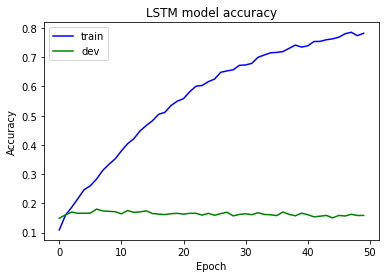

In [30]:
plot_acc(train_acc, dev_acc)

Yikes, no improvement... perhaps we should reconsider our architecture or try to find more data. What classes are we getting wrong?

In [ ]:
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)
matrix = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))
print(matrix)

Perhaps the class labels are not as orthogonalized as we originally expected. This may be worth revisiting.